In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import BaseEstimator, TransformerMixin
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### what is Linear Discriminant Analysis?

- The algorithm involves developing a probabilistic model per class based on the specific distribution of observations for each input variable. A new example is then classified by calculating the conditional probability of it belonging to each class and selecting the class with the highest probability.
- It works by calculating summary statistics for the input features by class label, such as the mean and standard deviation. These statistics represent the model learned from the training data. 
- Predictions are made by estimating the probability that a new example belongs to each class label based on the values of each input feature. The class that results in the largest probability is then assigned to the example. As such, LDA may be considered a simple application of Bayes Theorem for classification.
- makes strong assumptions about the distribution of each input variable that the input variables are numeric and normally distributed and that they have the same variance (spread). If this is not the case, it may be desirable to transform the data to have a Gaussian distribution and standardize or normalize the data prior to modeling.
- It is a linear classification algorithm, like logistic regression. This means that classes are separated in the feature space by lines or hyperplanes. Extensions of the method can be used that allow other shapes, like Quadratic Discriminant Analysis (QDA), which allows curved shapes in the decision boundary.

(source: https://machinelearningmastery.com/linear-discriminant-analysis-with-python/)

In [ ]:
data = pd.read_csv('WikiLarge_Train.csv', encoding="utf-8")

In [ ]:
def clean(data):
    # create a new column of text data, lower case all words 
    data["cleaned_text"] = data['original_text'].str.lower()

    # remove "-LRB-", "-LRB-", non-alphabets and non-ascii characters
    data['cleaned_text'] = data['cleaned_text'].str.replace("-lrb-", '')
    data['cleaned_text'] = data['cleaned_text'].str.replace("-rrb-", '')
    data["cleaned_text"] = data["cleaned_text"].str.encode('ascii', 'ignore').str.decode('ascii')

    # remove space >1
    data["cleaned_text"] = data["cleaned_text"].str.replace('[\s]{2,}', ' ')

    # remove space at the begining and the end of each sentence
    data["cleaned_text"] = data["cleaned_text"].str.strip()
    return data

In [ ]:
# cleaned data
data = clean(data)
# data.head()

In [ ]:
data.shape

(416768, 3)

In [ ]:
# check no non-ascii characters
count = 0
for sentence in data['cleaned_text']:
    if sentence.isascii() == False:
        count += 1
count

0

In [ ]:
# length of the sentence could be a indicator of complexity
# add a column of length to the data (this process takes a few minutes)

data['length'] = data['cleaned_text'].apply(lambda x: len(x.strip().split(" ")))
data.head()

,original_text,label,cleaned_text,length
0,There is manuscript evidence that Austen conti...,1,there is manuscript evidence that austen conti...,42
1,"In a remarkable comparative analysis , Mandaea...",1,"in a remarkable comparative analysis , mandaea...",23
2,"Before Persephone was released to Hermes , who...",1,"before persephone was released to hermes , who...",44
3,Cogeneration plants are commonly found in dist...,1,cogeneration plants are commonly found in dist...,39
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"geneva , ; , ; , ; ; is the second-most-populo...",30


In [ ]:
X = data[['cleaned_text',"length"]]
# X = data['cleaned_text']
y = data['label']

# train dataset 80%, test dataset 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.head()

,cleaned_text,length
0,there is manuscript evidence that austen conti...,42
1,"in a remarkable comparative analysis , mandaea...",23
2,"before persephone was released to hermes , who...",44
3,cogeneration plants are commonly found in dist...,39
4,"geneva , ; , ; , ; ; is the second-most-populo...",30


In [ ]:
def lemmatization(row):
    #make sure nltk.download('stopwords') and nltk.download('wordnet') work 
    stop = list(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    token_words= word_tokenize(row)
    token_words = [word for word in token_words if not word in stop]
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
def stemmer(row):
    #make sure nltk.download('stopwords') and nltk.download('wordnet') work 
    stop = list(stopwords.words('english'))
    porter_stemmer = PorterStemmer()
    token_words= word_tokenize(row)
    token_words = [word for word in token_words if not word in stop]
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter_stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
# Helper classes, functions
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col]
    
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        X here is a sparse matrix
        """
        return X.toarray()

### Hyperparameters tuning with pipeline

In [ ]:
# Pipeline #1
feat_process = Pipeline([
    ('feat_select', ColumnSelector(col='cleaned_text')),
#     ('vect', CountVectorizer()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('fs', SelectKBest()),
    ('stod', DataTransformer())
])

In [ ]:
feat_process.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feat_select', 'vect', 'tfidf', 'fs', 'stod', 'feat_select__col', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'fs__k', 'fs__score_func'])

In [ ]:
X_train.head()

,cleaned_text,length
304501,1979-80 buffalo sabres nhl 32 1880 74 1 4 2.36...,15
162313,diseases lentils in culture lentils are mentio...,36
336845,"railroads , like the lehigh valley railroad , ...",25
150625,an example of this would be an individual anim...,36
40240,both the matanuska and susitna rivers have maj...,12


In [ ]:
# check
# proc_feats = feat_process.fit_transform(X_train[:400], y_train[:400])
# print(proc_feats.shape)
# proc_feats

In [ ]:
pipe1 = Pipeline([
    ('preprocess', feat_process),
    ('clf', LinearDiscriminantAnalysis()) 
])

In [ ]:
parameters = {'preprocess__tfidf__use_idf': (True, False),
              'preprocess__vect__min_df': [6,8],
             'preprocess__vect__max_df': [0.8,0.9],
             'preprocess__vect__max_features':[10000,20000],
                'preprocess__vect__ngram_range':[(1,2)],
#             'preprocess__vect__preprocessor':[stemmer],#, lemmatization],
             'preprocess__fs__k':[100,1000]}

In [ ]:
# cross validation
# parameters = {
#     'preprocess__tfidf__use_idf': (True, False),
#     'preprocess__vect__min_df': ([6,8,10]),
#     'preprocess__vect__max_df': [0.8,0.9, 0.95],
#     'preprocess__vect__max_features':[100,500,1000],
#     'preprocess__vect__ngram_range':[(1,1), (1,2), (1,3)],
#     'fs__score_func':[chi2],
#     'fs__k':[10, 100, 1000],
#     'clf__solver': ['svd', 'lsqr', 'eigen']
# }

In [ ]:
t0 = time.time()
lda_clf1 = GridSearchCV(pipe1, parameters, cv=5, n_jobs=-1)
lda_clf1 = lda_clf1.fit(X_train, y_train)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

time = 40.71934108336767 mins


In [ ]:
print(lda_clf1.best_score_)
print(lda_clf1.best_params_)

0.6361760469491788
{'preprocess__fs__k': 100, 'preprocess__tfidf__use_idf': False, 'preprocess__vect__max_df': 0.8, 'preprocess__vect__max_features': 10000, 'preprocess__vect__min_df': 6, 'preprocess__vect__ngram_range': (1, 2)}


In [ ]:
pred = lda_clf1.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, pred))

metrics.confusion_matrix(y_test, pred)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     41549
           1       0.63      0.65      0.64     41805

    accuracy                           0.64     83354
   macro avg       0.64      0.64      0.64     83354
weighted avg       0.64      0.64      0.64     83354



array([[25924, 15625],
       [14777, 27028]], dtype=int64)

In [ ]:
# pipeline 2: tuning max_features and k

In [ ]:
parameters1 = {'preprocess__tfidf__use_idf': (True, False),
              'preprocess__vect__min_df': [6,8],
             'preprocess__vect__max_df': [0.8,0.9],
             'preprocess__vect__max_features':[40000, 80000],
                'preprocess__vect__ngram_range':[(1,2)],
#             'preprocess__vect__preprocessor':[stemmer],#, lemmatization],
             'preprocess__fs__k':[55,85]}

In [ ]:
t0 = time.time()
lda_clf2 = GridSearchCV(pipe1, parameters1, cv=5, n_jobs=-1)
lda_clf2 = lda_clf2.fit(X_train, y_train)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

time = 20.60633047421773 mins


In [ ]:
print(lda_clf2.best_score_)
print(lda_clf2.best_params_)

0.6314431915621841
{'preprocess__fs__k': 85, 'preprocess__tfidf__use_idf': False, 'preprocess__vect__max_df': 0.8, 'preprocess__vect__max_features': 40000, 'preprocess__vect__min_df': 6, 'preprocess__vect__ngram_range': (1, 2)}


In [ ]:
pred1 = lda_clf2.predict(X_test)

In [ ]:
prob_0 = lda_clf2.predict_proba(X_test)[:,0]
prob_1 = lda_clf2.predict_proba(X_test)[:,1]

In [ ]:
print(metrics.classification_report(y_test, pred1))

metrics.confusion_matrix(y_test, pred1)

              precision    recall  f1-score   support

           0       0.63      0.62      0.63     41549
           1       0.63      0.64      0.64     41805

    accuracy                           0.63     83354
   macro avg       0.63      0.63      0.63     83354
weighted avg       0.63      0.63      0.63     83354



array([[25876, 15673],
       [15038, 26767]], dtype=int64)

In [ ]:
# calculate scores
auc_score = roc_auc_score(y_test, pred1)
auc_score

0.6315325006703034

In [ ]:
# calculate roc curves
fpr0, tpr0, _ = roc_curve(y_test, prob_0)
fpr1, tpr1, _ = roc_curve(y_test, prob_1)

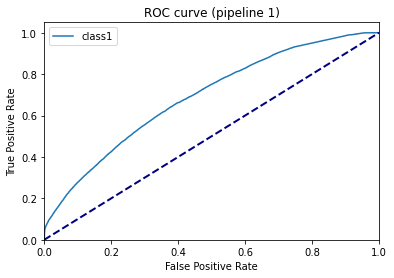

In [ ]:
# plt.plot(fpr0, tpr0)
plt.plot(fpr1, tpr1, label='class1')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (pipeline 1)')
plt.legend();

In [ ]:
# pipeline 3: tuning max_features and k hodling the rest fixed base on above results

In [ ]:
parameters3 = {'preprocess__tfidf__use_idf': [False],
              'preprocess__vect__min_df': [6],
             'preprocess__vect__max_df': [0.8],
             'preprocess__vect__max_features':[40000, 80000,100000],
                'preprocess__vect__ngram_range':[(1,2)],
#             'preprocess__vect__preprocessor':[stemmer],#, lemmatization],
             'preprocess__fs__k':[100,200,300,400]}

In [ ]:
t0 = time.time()
lda_clf3 = GridSearchCV(pipe1, parameters3, cv=5, n_jobs=-1)
lda_clf3 = lda_clf3.fit(X_train, y_train)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

time = 22.821058587233225 mins


In [ ]:
pred2 = lda_clf3.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, pred2))

metrics.confusion_matrix(y_test, pred2)

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     41549
           1       0.66      0.66      0.66     41805

    accuracy                           0.66     83354
   macro avg       0.66      0.66      0.66     83354
weighted avg       0.66      0.66      0.66     83354



array([[27377, 14172],
       [14324, 27481]], dtype=int64)

In [ ]:
print(lda_clf3.best_score_)
print(lda_clf3.best_params_)

0.6565531142689542
{'preprocess__fs__k': 300, 'preprocess__tfidf__use_idf': False, 'preprocess__vect__max_df': 0.8, 'preprocess__vect__max_features': 40000, 'preprocess__vect__min_df': 6, 'preprocess__vect__ngram_range': (1, 2)}


In [ ]:
# calculate scores
auc_score = roc_auc_score(y_test, pred2)
auc_score

0.6581351589777944

In [ ]:
# calculate roc curves
prob_01 = lda_clf3.predict_proba(X_test)[:,0]
prob_11 = lda_clf3.predict_proba(X_test)[:,1]

fpr01, tpr01, _ = roc_curve(y_test, prob_0)
fpr11, tpr11, _ = roc_curve(y_test, prob_1)

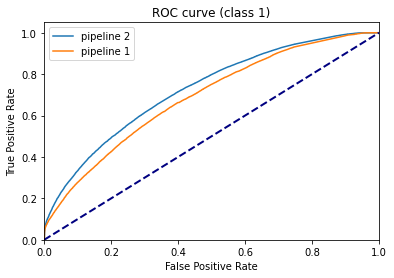

In [ ]:
plt.plot(fpr11, tpr11, label='pipeline 2')
plt.plot(fpr1, tpr1, label='pipeline 1')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (class 1)')
plt.legend();